In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_text, plot_tree

import warnings
warnings.filterwarnings("ignore")

In [67]:
# Load dataset
df = pd.read_csv("credit_risk_dataset.csv")

df.drop(columns=["cb_person_default_on_file"], inplace=True)
print("\nUpdated columns:", df.columns)

# Display first few rows
print(df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Check data types
print("\nData types:\n", df.dtypes)


Updated columns: Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL       

In [68]:
print(df.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')


In [69]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [70]:
# Fill missing values: Median for numerical, Mode for categorical
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Confirm no missing values
print("\nMissing values after filling:\n", df.isnull().sum())


Missing values after filling:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_cred_hist_length    0
dtype: int64


In [71]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Encode categorical variables and store mappings
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Print label mapping for each categorical feature
    print(f"Label Encoding for {col}:")
    for i, class_name in enumerate(le.classes_):
        print(f"  {class_name} -> {i}")
    print("\n" + "-" * 30 + "\n")  # Separator for readability

# Check dataset after encoding
print(df.head())

Label Encoding for person_home_ownership:
  MORTGAGE -> 0
  OTHER -> 1
  OWN -> 2
  RENT -> 3

------------------------------

Label Encoding for loan_intent:
  DEBTCONSOLIDATION -> 0
  EDUCATION -> 1
  HOMEIMPROVEMENT -> 2
  MEDICAL -> 3
  PERSONAL -> 4
  VENTURE -> 5

------------------------------

Label Encoding for loan_grade:
  A -> 0
  B -> 1
  C -> 2
  D -> 3
  E -> 4
  F -> 5
  G -> 6

------------------------------

   person_age  person_income  person_home_ownership  person_emp_length  \
0          22          59000                      3              123.0   
1          21           9600                      2                5.0   
2          25           9600                      0                1.0   
3          23          65500                      3                4.0   
4          24          54400                      3                8.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_status  \
0            4           3      35000          16.02    

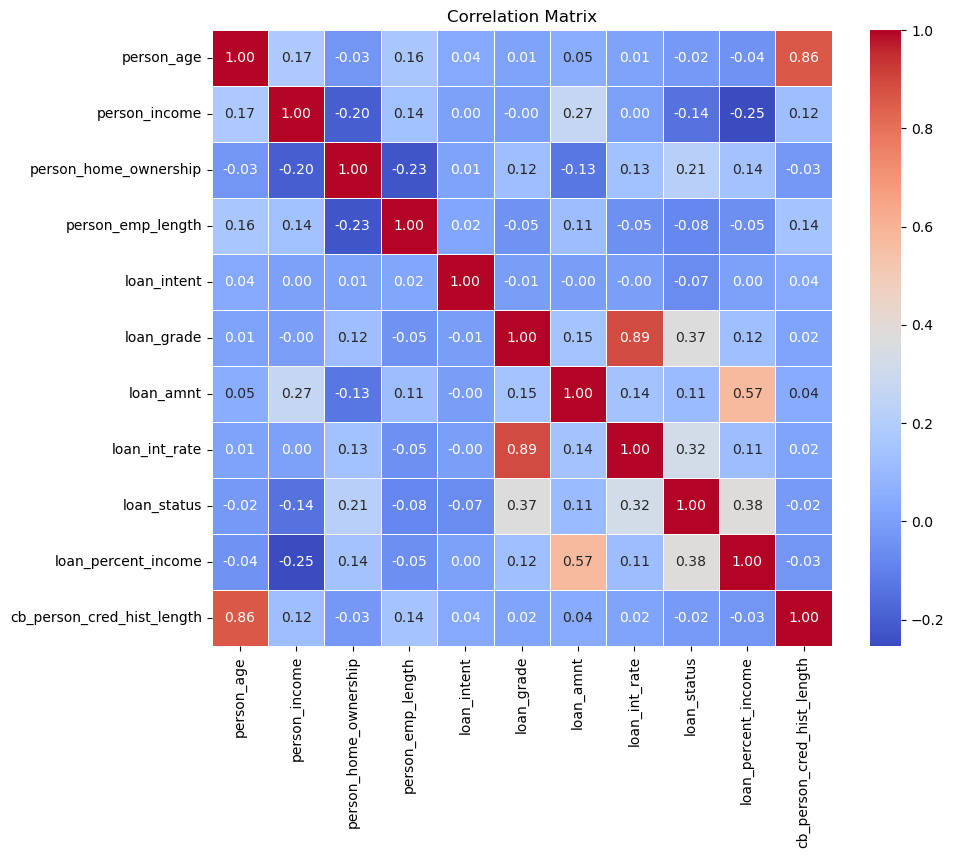

In [72]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [73]:
X = df.drop(columns=["loan_status"])  # Features
y = df["loan_status"]  # Target variable

# Check class distribution before SMOTE
print("\nClass Distribution Before SMOTE:\n", y.value_counts())



Class Distribution Before SMOTE:
 loan_status
0    25473
1     7108
Name: count, dtype: int64


In [74]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Print shape to verify
print("Original feature count:", X.shape[1])
print("Feature count after PCA:", X_pca.shape[1])


Original feature count: 10
Feature count after PCA: 7


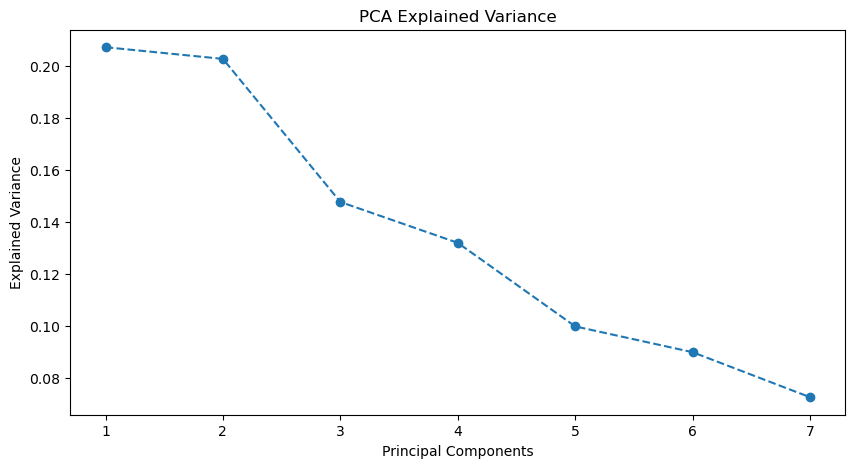

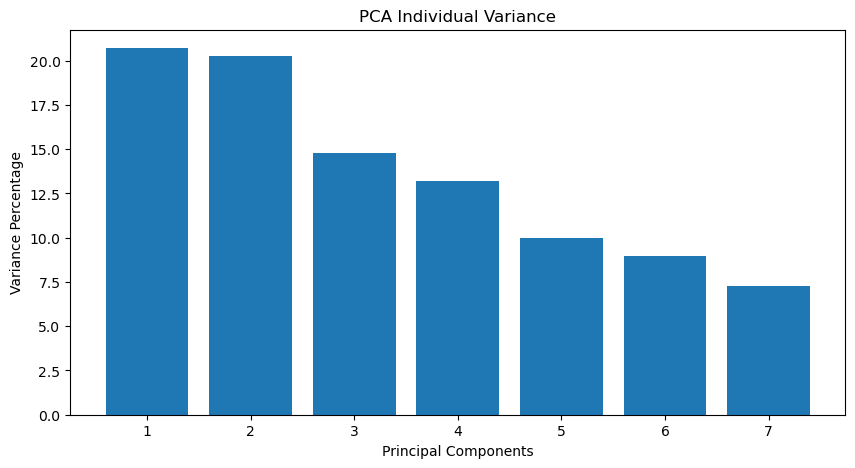

In [75]:
# Plot Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

# Individual Variance Plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Principal Components")
plt.ylabel("Variance Percentage")
plt.title("PCA Individual Variance")
plt.show()


In [76]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\nClass distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts())



Class distribution after SMOTE:
 loan_status
0    20401
1    20401
Name: count, dtype: int64


In [77]:
# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)


Model Accuracy: 0.8750959030228633

Confusion Matrix:
 [[4660  412]
 [ 402 1043]]

Cross-validation Accuracy: 0.910274304979926


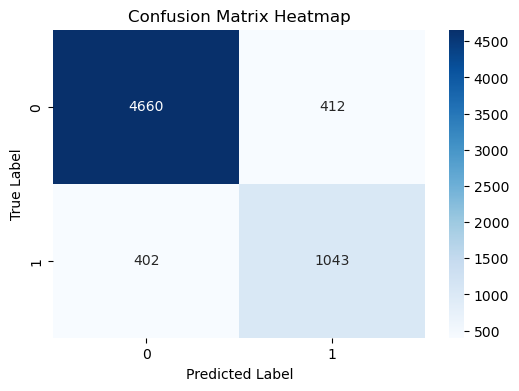

In [78]:
# Make predictions
y_pred = rf.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", accuracy)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-Validation Score
cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5)
print("\nCross-validation Accuracy:", cv_scores.mean())

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

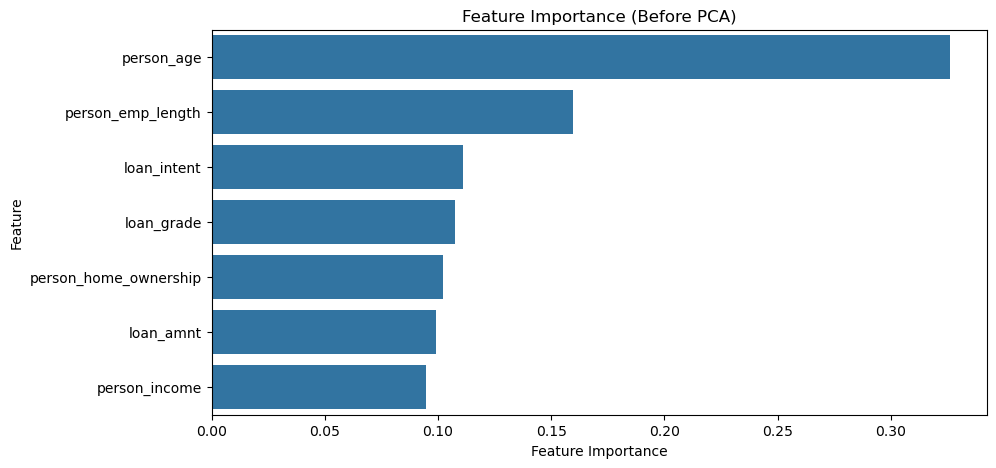

In [80]:
# Feature importance plot
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Before PCA)")
plt.show()

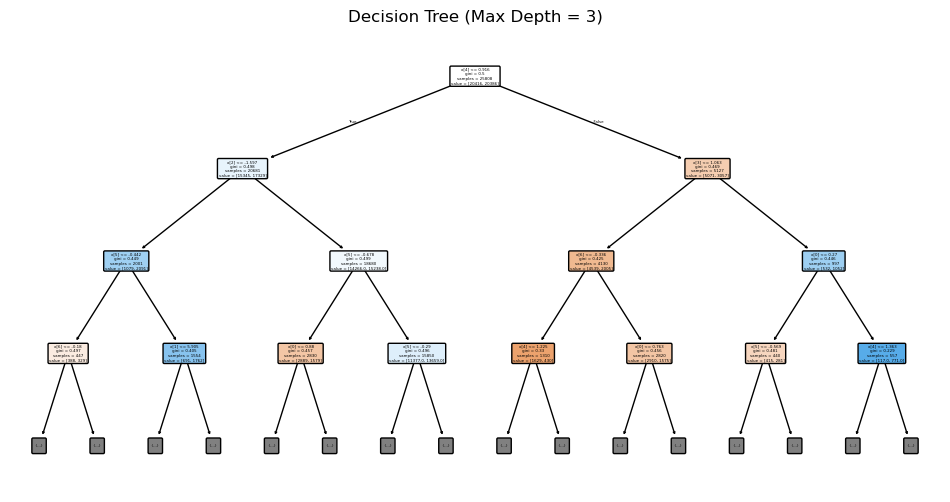

In [81]:
# Visualize a single decision tree from the random forest
tree = rf.estimators_[0]
plt.figure(figsize=(12, 6))
plot_tree(tree, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (Max Depth = 3)")
plt.show()

In [82]:
print(f"Features used in training: {X.shape[1]}")
print("Feature Names Used in Training:", list(X.columns))
print("Expected Feature Count After PCA:", X_pca.shape[1])

Features used in training: 10
Feature Names Used in Training: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Expected Feature Count After PCA: 7


In [84]:
# Define a new data point (10 original features)
new_data = {
    'person_age': 22,
    'person_income': 50000,
    'person_emp_length': 2,
    'loan_amnt': 20000,
    'loan_int_rate': 10.0,
    'loan_percent_income': 0.29,
    'cb_person_cred_hist_length': 3,
    'loan_grade': 3,               # Encoded value
    'loan_intent': 0,              # Encoded value
    'person_home_ownership': 0      # Encoded value
}

# Convert to DataFrame
new_df = pd.DataFrame([new_data])

# Ensure column order matches training data
new_df = new_df[X.columns]

# Scale new data using trained StandardScaler
new_scaled = scaler.transform(new_df)

# Apply PCA transformation to match training data shape
new_pca = pca.transform(new_scaled)

# Predict class and probability
new_pred = rf.predict(new_pca)
new_pred_prob = rf.predict_proba(new_pca)[:, 1]

# Output results
print("\nPrediction Result for New Data Point:")
print(f"Predicted Probability of Default: {new_pred_prob[0]:.4f}")
print(f"Predicted Credit Risk: {'High Risk' if new_pred[0] == 1 else 'Low Risk'}")



Prediction Result for New Data Point:
Predicted Probability of Default: 0.3900
Predicted Credit Risk: Low Risk


In [85]:
# Function to get user input for prediction
def get_user_input():
    print("\nEnter values for prediction:")

    # Numerical inputs with example values
    person_age = float(input("Enter Age (e.g., 30, 40, 50): "))
    person_income = float(input("Enter Income (e.g., 45000, 60000, 75000): "))
    person_emp_length = float(input("Enter Employment Length in years (e.g., 5, 7, 10): "))
    loan_amnt = float(input("Enter Loan Amount (e.g., 10000, 15000, 25000): "))
    loan_int_rate = float(input("Enter Loan Interest Rate % (e.g., 10.5, 12.0, 14.5): "))
    loan_percent_income = float(input("Enter Loan Percent Income (e.g., 0.20, 0.25, 0.30): "))
    cb_person_cred_hist_length = float(input("Enter Credit History Length in years (e.g., 6, 8, 12): "))

    # Categorical inputs with label mapping
    print("\nLoan Grade Encoding:")
    print("A -> 0, B -> 1, C -> 2, D -> 3, E -> 4, F -> 5, G -> 6 ")
    loan_grade = int(input("Enter Loan Grade (choose from above): "))

    print("\nLoan Intent Encoding:")
    print("PERSONAL -> 0, EDUCATION -> 1, MEDICAL -> 2, VENTURE -> 3, HOMEIMPROVEMENT -> 4, DEBTCONSOLIDATION -> 5")
    loan_intent = int(input("Enter Loan Intent (choose from above): "))

    print("\nHome Ownership Encoding:")
    print("RENT -> 0, MORTGAGE -> 1, OWN -> 2, OTHER -> 3")
    person_home_ownership = int(input("Enter Home Ownership (choose from above): "))

    # Return input as dictionary
    return {
        'person_age': person_age,
        'person_income': person_income,
        'person_emp_length': person_emp_length,
        'loan_amnt': loan_amnt,
        'loan_int_rate': loan_int_rate,
        'loan_percent_income': loan_percent_income,
        'cb_person_cred_hist_length': cb_person_cred_hist_length,
        'loan_grade': loan_grade,
        'loan_intent': loan_intent,
        'person_home_ownership': person_home_ownership
    }

# Get user input
user_data = get_user_input()

# Convert to DataFrame
new_df_user = pd.DataFrame([user_data])

# Ensure column order matches training data
new_df_user = new_df_user[X.columns]

# Display user input
print("\nUser Entered Data for Prediction:")
print(new_df_user)

# Scale user input
new_scaled = scaler.transform(new_df_user)

# Apply PCA transformation
new_pca = pca.transform(new_scaled)

# Predict class and probability
new_pred = rf.predict(new_pca)
new_pred_prob = rf.predict_proba(new_pca)[:, 1]

# Output results
print("\nPrediction Result for New Data Point:")
print(f"Predicted Probability of Default: {new_pred_prob[0]:.4f}")
print(f"Predicted Credit Risk: {'High Risk' if new_pred[0] == 1 else 'Low Risk'}")


Enter values for prediction:


Enter Age (e.g., 30, 40, 50):  25
Enter Income (e.g., 45000, 60000, 75000):  30000
Enter Employment Length in years (e.g., 5, 7, 10):  3
Enter Loan Amount (e.g., 10000, 15000, 25000):  25000
Enter Loan Interest Rate % (e.g., 10.5, 12.0, 14.5):  10.0
Enter Loan Percent Income (e.g., 0.20, 0.25, 0.30):  0.30
Enter Credit History Length in years (e.g., 6, 8, 12):  4



Loan Grade Encoding:
A -> 0, B -> 1, C -> 2, D -> 3, E -> 4, F -> 5, G -> 6 


Enter Loan Grade (choose from above):  3



Loan Intent Encoding:
PERSONAL -> 0, EDUCATION -> 1, MEDICAL -> 2, VENTURE -> 3, HOMEIMPROVEMENT -> 4, DEBTCONSOLIDATION -> 5


Enter Loan Intent (choose from above):  4



Home Ownership Encoding:
RENT -> 0, MORTGAGE -> 1, OWN -> 2, OTHER -> 3


Enter Home Ownership (choose from above):  2



User Entered Data for Prediction:
   person_age  person_income  person_home_ownership  person_emp_length  \
0        25.0        30000.0                      2                3.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0            4           3    25000.0           10.0                  0.3   

   cb_person_cred_hist_length  
0                         4.0  

Prediction Result for New Data Point:
Predicted Probability of Default: 0.6400
Predicted Credit Risk: High Risk
